# 3. From a simple denoising model on MNIST to a basic Diffusion one.

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (08/04/2023)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.6.2)
- Torch (tested on v1.12.1)

### Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# CUDA check
CUDA = True
device = "cuda" if (torch.cuda.is_available() and CUDA) else "cpu"
print(torch.cuda.is_available())
print(device)

False
cpu


### MNIST Dataset

In [3]:
# Load the MNIST dataset
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transform)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

In [4]:
# Test the model on a single image
test_dataset = datasets.MNIST(root = './data', train = False, download = True, transform = transform)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

### Model

Fully connected and hidden layer size can be chosen.

In [5]:
class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(28 * 28 + 1, 400),
            nn.ReLU(),
            nn.Linear(400, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28)
        )

    def forward(self, x, t):
        x = torch.cat([x, t.expand(x.size(0), 1)], dim = 1)
        return self.network(x)

### Training a denoising model

In [6]:
# Hyperparameters
epochs = 10
batch_size = 64
learning_rate = 1e-3
num_timesteps = 5
noise_schedule = torch.linspace(0, 1, num_timesteps)

In [7]:
# Initialize the model, loss function, and optimizer
model = DiffusionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [8]:
# Training loop
# (Very long, use at your own discretion!)
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        noisy_data = data.clone()

        # Apply multiple noising steps
        for t in range(num_timesteps-1):
            noisy_data += torch.randn_like(noisy_data)*torch.sqrt(noise_schedule[t+1]-noise_schedule[t])

        optimizer.zero_grad()
        loss = 0

        # Apply multiple denoising steps
        for t in reversed(range(num_timesteps-1)):
            denoised_data = noisy_data-torch.randn_like(noisy_data)*torch.sqrt(noise_schedule[t+1]-noise_schedule[t])
            target_score = (data-denoised_data)/(noise_schedule[t+1]-noise_schedule[t])
            score_prediction = model(denoised_data, noise_schedule[t].view(-1, 1))
            loss += criterion(score_prediction, target_score)

        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch+1}/{epochs}, Batch: {batch_idx}/{len(train_loader)}, Loss: {loss.item()}')

Epoch: 1/10, Batch: 0/938, Loss: 79.81517028808594
Epoch: 1/10, Batch: 100/938, Loss: 74.13182067871094
Epoch: 1/10, Batch: 200/938, Loss: 65.92903137207031
Epoch: 1/10, Batch: 300/938, Loss: 61.54655075073242
Epoch: 1/10, Batch: 400/938, Loss: 58.606876373291016
Epoch: 1/10, Batch: 500/938, Loss: 56.519989013671875
Epoch: 1/10, Batch: 600/938, Loss: 55.0623893737793
Epoch: 1/10, Batch: 700/938, Loss: 52.777042388916016
Epoch: 1/10, Batch: 800/938, Loss: 52.68815231323242
Epoch: 1/10, Batch: 900/938, Loss: 51.90736770629883
Epoch: 2/10, Batch: 0/938, Loss: 51.92570114135742
Epoch: 2/10, Batch: 100/938, Loss: 51.13304901123047
Epoch: 2/10, Batch: 200/938, Loss: 50.7455940246582
Epoch: 2/10, Batch: 300/938, Loss: 50.37187576293945
Epoch: 2/10, Batch: 400/938, Loss: 50.616615295410156
Epoch: 2/10, Batch: 500/938, Loss: 50.14930725097656
Epoch: 2/10, Batch: 600/938, Loss: 49.96846008300781
Epoch: 2/10, Batch: 700/938, Loss: 50.80589294433594
Epoch: 2/10, Batch: 800/938, Loss: 49.6633987426

### Testing denoising model on noised MNIST images

In [13]:
def test_and_evaluate(model, test_dataset, noise_schedule, num_timesteps):
    # Get a sample from the test dataset
    test_sample, _ = test_dataset[0]
    test_sample = test_sample.view(-1)

    # Add noise to the sample
    noisy_sample = test_sample.clone()
    for t in range(num_timesteps-1):
        noisy_sample += torch.randn_like(noisy_sample)*torch.sqrt(noise_schedule[t+1]-noise_schedule[t])

    # Denoise the sample using the trained model
    denoised_sample = noisy_sample.clone()
    for t in reversed(range(num_timesteps-1)):
        denoised_data = denoised_sample-torch.randn_like(denoised_sample)*torch.sqrt(noise_schedule[t+1]-noise_schedule[t])
        score_prediction = model(denoised_data.unsqueeze(0), noise_schedule[t].view(1, 1)).squeeze(0)
        denoised_sample = denoised_data+score_prediction*(noise_schedule[t+1]-noise_schedule[t])

    # Visualize the images
    fig, axs = plt.subplots(1, 3, figsize = (12, 4))
    axs[0].imshow(test_sample.view(28, 28).detach().numpy(), cmap = 'gray')
    axs[0].set_title("Original")
    axs[1].imshow(noisy_sample.view(28, 28).detach().numpy(), cmap = 'gray')
    axs[1].set_title("Noisy")
    axs[2].imshow(denoised_sample.view(28, 28).detach().numpy(), cmap = 'gray')
    axs[2].set_title("Denoised")
    plt.show()

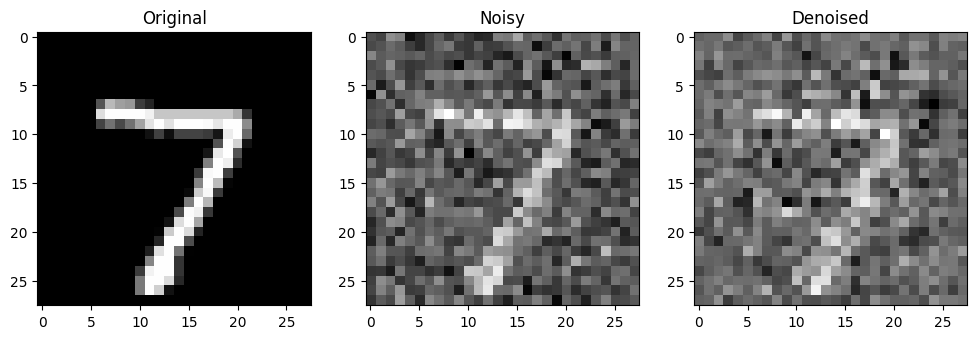

In [15]:
# Test and evaluate the trained model
test_and_evaluate(model, test_dataset, noise_schedule, num_timesteps)